# Stock Price Prediction with LSTM

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='google.protobuf')

In [10]:
# --- Core imports
from datetime import date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Silence optional noisy protobuf warnings (safe to remove)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")

# --- Your project modules
from src.data_loader import download_stock_data
from src.preprocessing import preprocess_data
from src.model_builder import build_lstm_model, build_gru_model
from src.train import train_model
from src.evaluate import plot_predictions

# --- User controls (edit these!)
# --- Volatile, high-momentum stock
TICKER = "TSLA"          # Tesla
YEARS_BACK = 3
WINDOW = 60
EPOCHS = 10
BATCH_SIZE = 32
MODEL_TYPE = "gru"       # Try GRU for comparison
FORECAST_STEPS = 20

In [11]:
end_date = date.today().isoformat()
start_date = (date.today() - timedelta(days=YEARS_BACK * 365)).isoformat()

data = download_stock_data(TICKER, start_date, end_date)  # returns ['Close','Volume']
data.columns.name = None
data = data.dropna()

print(f"{TICKER}: {data.index.min().date()} → {data.index.max().date()} | rows: {len(data)}")
data.tail()

[*********************100%***********************]  1 of 1 completed

TSLA: 2022-08-15 → 2025-08-12 | rows: 751


Price,Close,Volume
Ticker,TSLA,TSLA
Date,,
2025-08-06,319.910004,78523600
2025-08-07,322.269989,66658700
2025-08-08,329.649994,91200300
2025-08-11,339.029999,105320200
2025-08-12,340.839996,80522100


In [12]:
# Ensure columns have no name (cleaner for model input)
# data.columns.name = None  # This removes the 'Price' label if present

# Use just 'Close' for this first version (simplifies inverse-scaling & plotting)
X, y, scaler = preprocess_data(data[['Close']], sequence_length=WINDOW)
print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (691, 60, 1) | y shape: (691,)


In [13]:
# Chronological split (no shuffle!)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size],  X[train_size:]
y_train, y_test = y[:train_size],  y[train_size:]

# Choose model type
if MODEL_TYPE.lower() == "gru":
    model = build_gru_model((X.shape[1], X.shape[2]))
else:
    model = build_lstm_model((X.shape[1], X.shape[2]))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0468 - val_loss: 0.0042
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0131 - val_loss: 0.0136
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0024 - val_loss: 0.0022


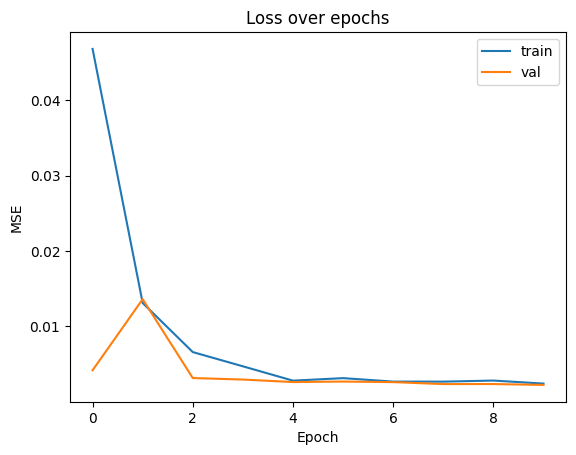

In [14]:
history = train_model(
    model, X_train, y_train,
    X_test, y_test,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Optional: visualize training curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss over epochs'); plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


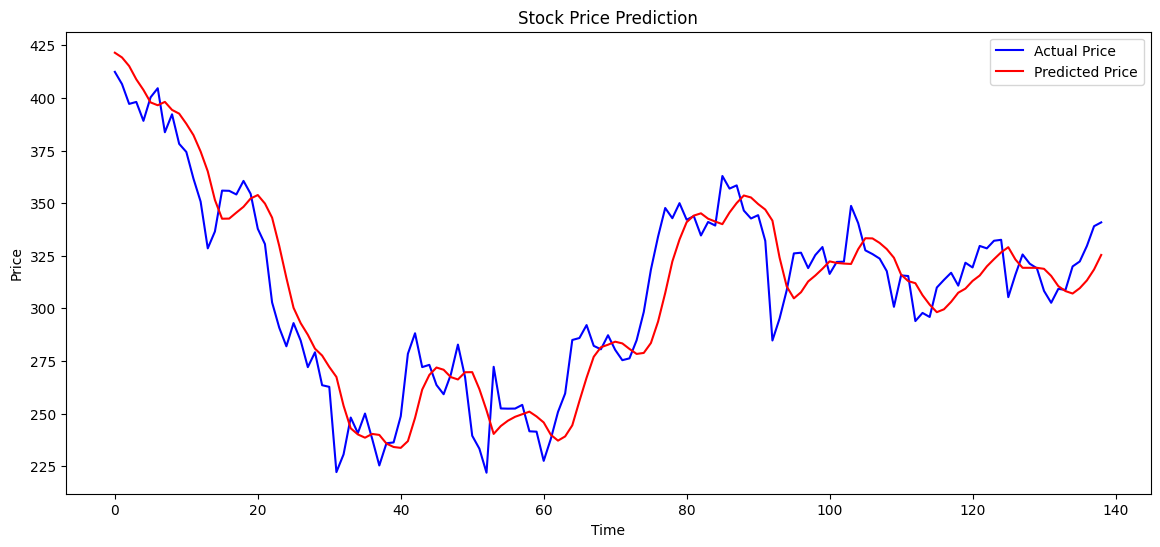

In [15]:
# Predict on the test sequences
pred_test = model.predict(X_test)

# Inverse-scale predictions & labels back to dollars
pred_test_inv = scaler.inverse_transform(pred_test)[:, 0]
y_test_inv   = scaler.inverse_transform(y_test.reshape(-1,1))[:, 0]

plot_predictions(y_test_inv, pred_test_inv)

In [16]:
def forecast_future(model, close_series: pd.Series, scaler, window: int, steps: int):
    """
    Recursive one-step-ahead forecast.
    close_series: pandas Series of historical Close prices (unscaled)
    returns: np.array of length `steps` with future prices in original scale
    """
    # Scale full close series to get the last window in scaled space
    scaled_full = scaler.transform(close_series.values.reshape(-1, 1))  # (N,1)
    window_seq = scaled_full[-window:].copy()                           # (window,1)

    preds_scaled = []
    for _ in range(steps):
        x_input = window_seq.reshape(1, window, 1)  # (1, window, features)
        next_scaled = model.predict(x_input, verbose=0)[0, 0]
        preds_scaled.append(next_scaled)
        # slide window forward with the new prediction
        window_seq = np.vstack([window_seq[1:], [[next_scaled]]])

    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()
    return preds

# Generate future prices
future_prices = forecast_future(model, data['Close'], scaler, WINDOW, FORECAST_STEPS)

# Build business-day index for future dates (skip weekends/holidays)
last_date = data.index[-1]
future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=FORECAST_STEPS)

future_df = pd.DataFrame({'Forecast': future_prices}, index=future_dates)
future_df.head()

,Forecast
2025-08-13,331.534729
2025-08-14,333.390594
2025-08-15,333.926147
2025-08-18,333.932037
2025-08-19,333.693604


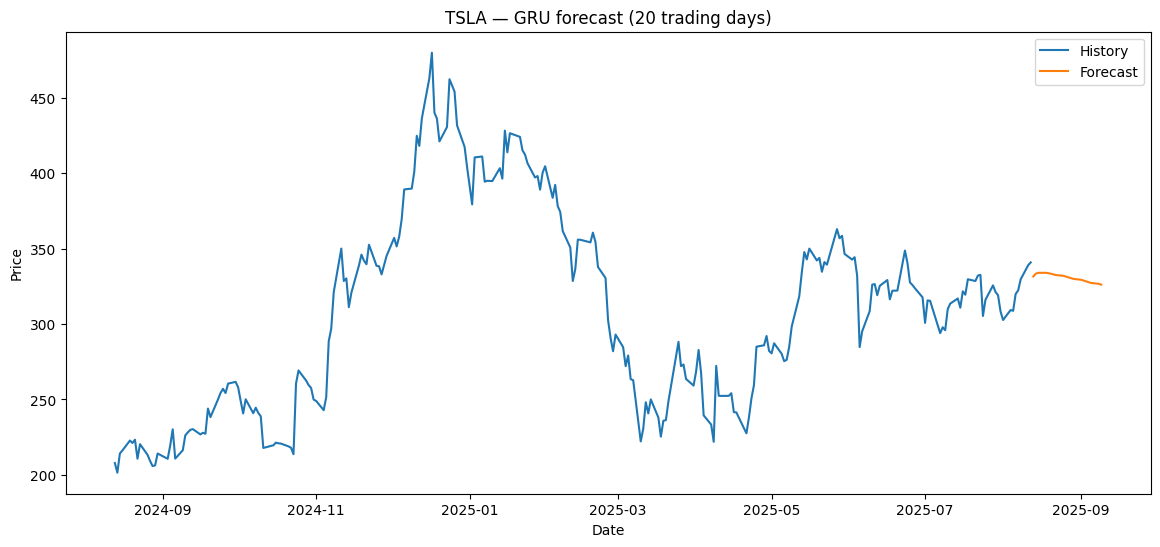

In [17]:
plt.figure(figsize=(14,6))
history_tail = data['Close'].iloc[-250:]  # show last ~250 trading days for context
plt.plot(history_tail.index, history_tail.values, label='History')
plt.plot(future_df.index, future_df['Forecast'], label='Forecast')
plt.title(f'{TICKER} — {MODEL_TYPE.upper()} forecast ({FORECAST_STEPS} trading days)')
plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.show()